# Interpretable forecasting with N-Beats

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

os.chdir("../../..")

In [2]:
import pandas as pd
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline
from pytorch_forecasting.data import NaNLabelEncoder
from examples.data import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

## Load data

In [3]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
validation = data.series.sample(20)


max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx < training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Calculate baseline error

In [4]:
# calculate baseline absolute error
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.5280)

## Train network 

Find optimal learning rate

In [5]:
trainer = pl.Trainer(max_epochs=100, gpus=0, weights_summary="top", gradient_clip_val=0.1)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Warning, `module_arguments` dropped from checkpoint. An attribute is not picklable Can't pickle local object '_apply_to_outputs.<locals>.decorator_fn.<locals>.new_func'
  warnings.warn(*args, **kwargs)

  | Name       | Type       | Params
------------------------------------------
0 | loss       | SMAPE      | 0     
1 | net_blocks | ModuleList | 134 K 
/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning:

/Users/distiller/project/conda/conda-bld/pytorch_1591914925853/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
Saving latest checkpoint..
LR finder stopped early due to diverging loss.


suggested learning rate: 0.007413102413009173


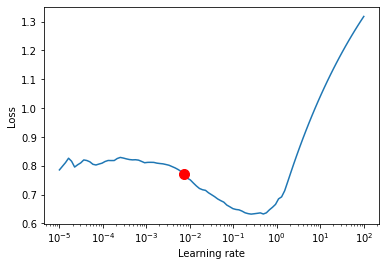

/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


In [6]:
# find optimal learning rate
res = trainer.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e2)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

Fit model

In [7]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    early_stop_callback=early_stop_callback,
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training, learning_rate=1.2e-2, log_interval=10, log_val_interval=1, weight_decay=1e-2
)

trainer.fit(
    net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name       | Type       | Params
------------------------------------------
0 | loss       | SMAPE      | 0     
1 | net_blocks | ModuleList | 134 K 


/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Saving latest checkpoint..


1

### Evaluate Results

In [8]:
# best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path = '/Users/beitnerjan/Documents/Github/temporal_fusion_transformer_pytorch/lightning_logs/version_212/checkpoints/epoch=19.ckpt'
best_model = NBeats.load_from_checkpoint(best_model_path)
print(best_model_path)

/Users/beitnerjan/Documents/Github/temporal_fusion_transformer_pytorch/lightning_logs/version_212/checkpoints/epoch=19.ckpt


We calculate the error which is approximately half of the baseline error

In [9]:
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.2053)

In [10]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

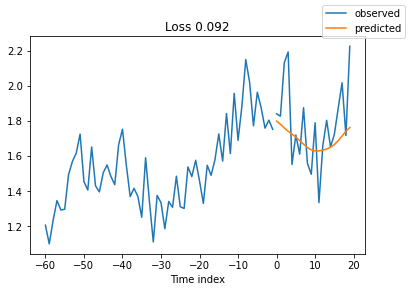

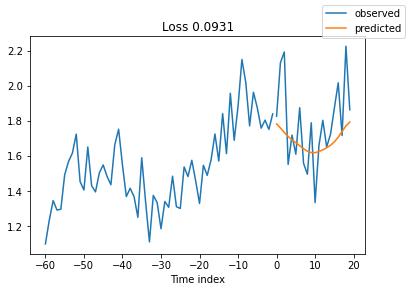

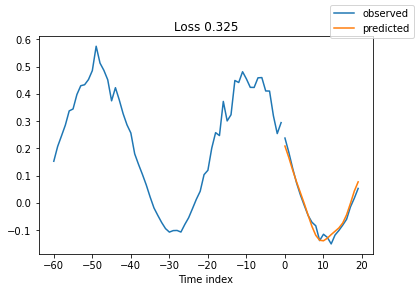

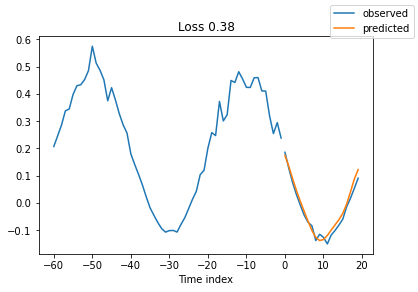

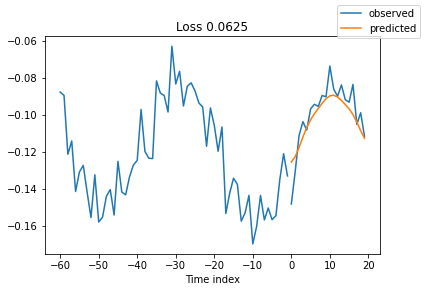

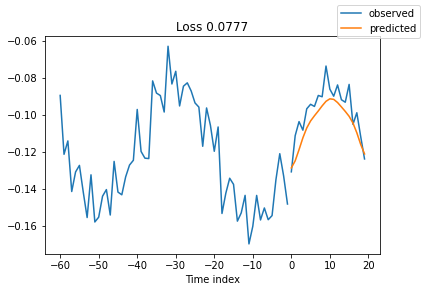

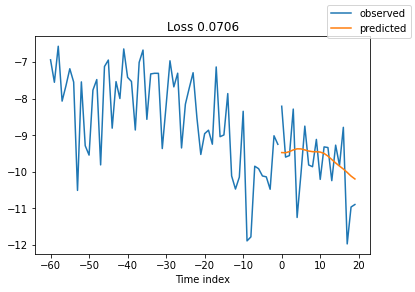

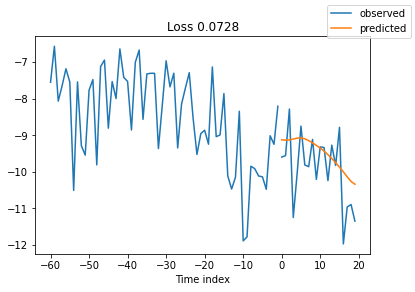

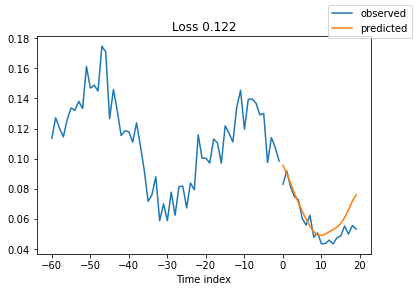

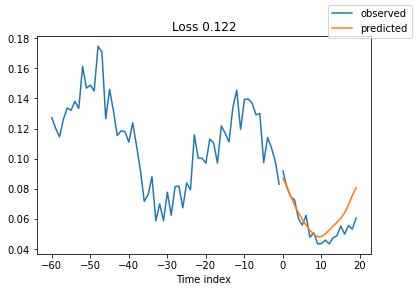

In [11]:
for idx in range(10):
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

## Interpret model

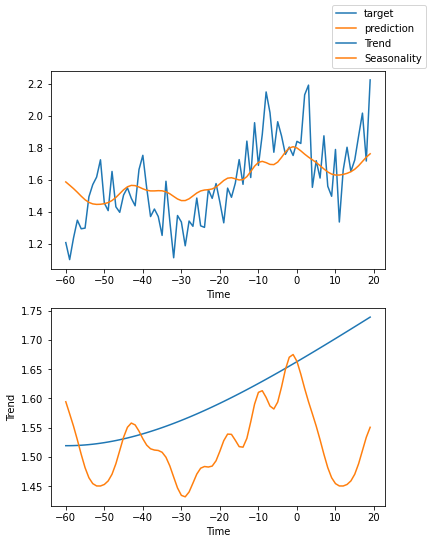

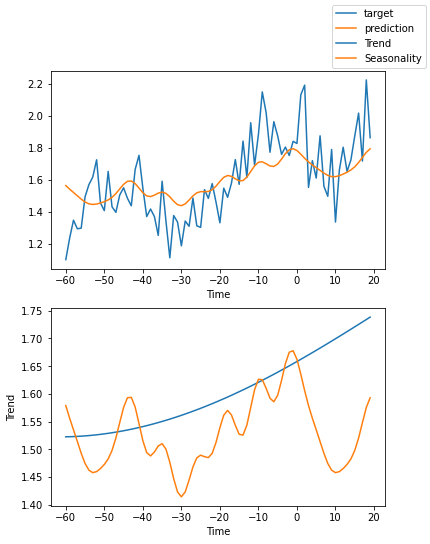

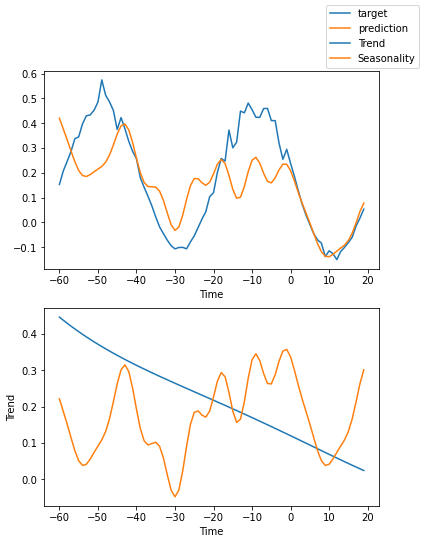

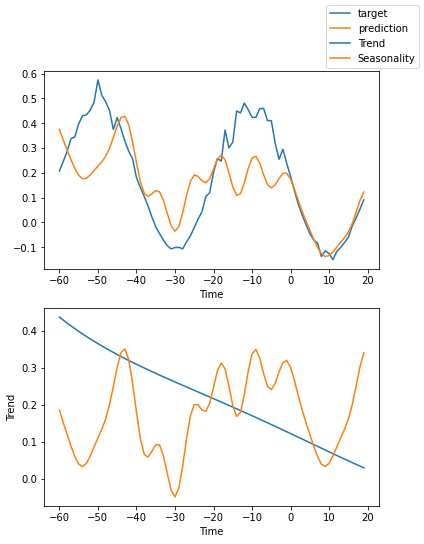

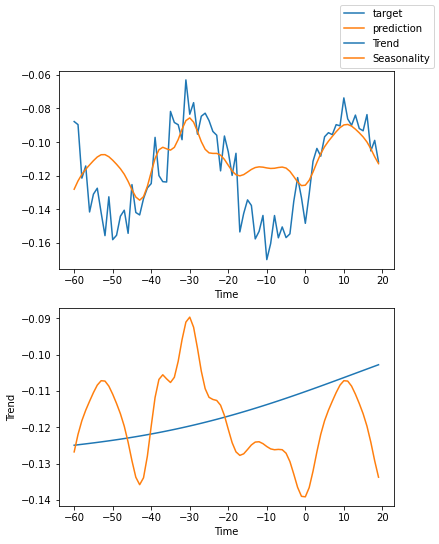

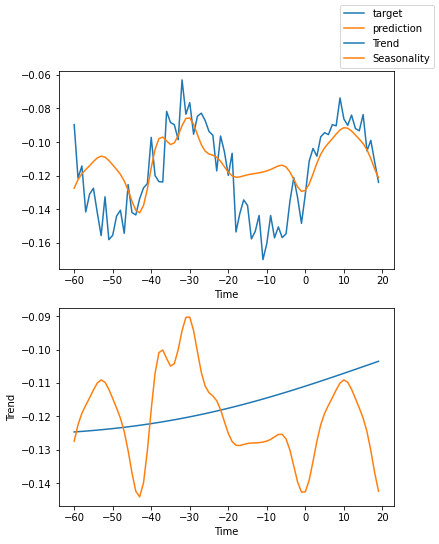

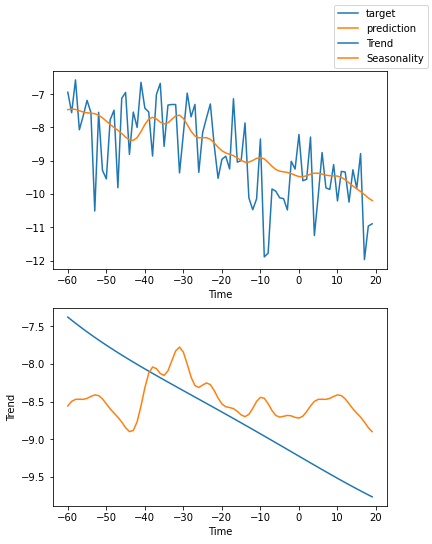

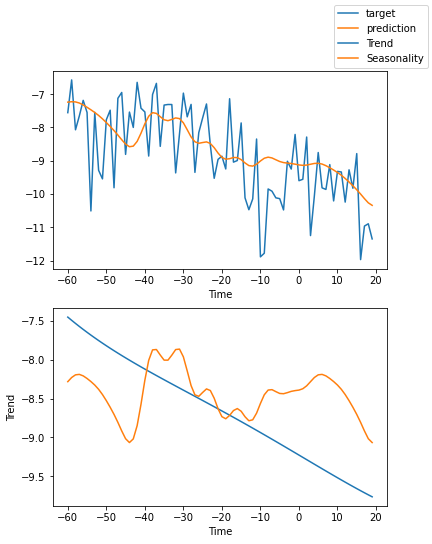

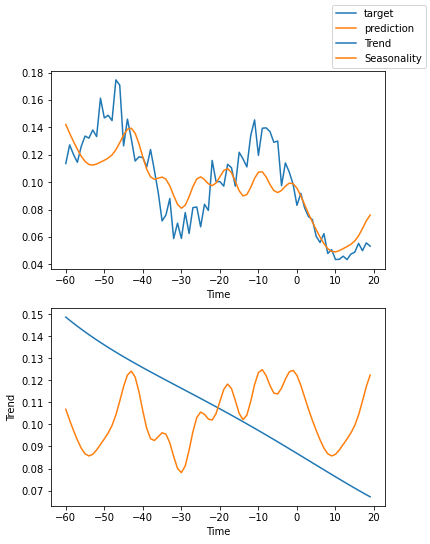

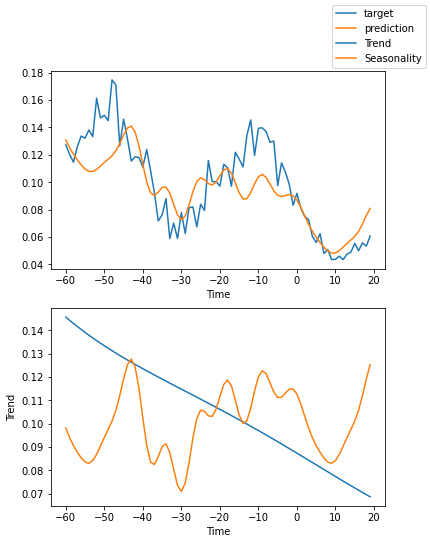

In [12]:
for idx in range(10):
    best_model.plot_interpretation(x, raw_predictions, idx=idx);